In [42]:
import pandas as pd
import numpy as np
#from keras.preprocessing.text import Tokenizer
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten


In [36]:
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [45]:
from keras.layers import Embedding


In [21]:
text=pd.read_excel('New_dataset.xlsx')
# Preprocessing thr data

In [14]:
from DataClean import DataCleaner
cleanData = DataCleaner()
sentences , emotions = cleanData.cleanData(text["Sentence"]) , text["Emotion"]


In [15]:
sentences.head()
#splitting the data into train, test and validation in 80:20 and 
# test , validation into 50:50

0    i m already feel somewhat strange give that i ...
1    i pm hehehe anyasimbi pm take a nap sweetie pm...
2    a boy phone me at night and want to talk to me...
3    i a feeling of curious satisfaction to be on t...
4                 a breakup with someone i really like
Name: Sentence, dtype: object

In [16]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(sentences, emotions, test_size=.2, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [17]:
# This mthod will tokenize the sentence and append a tag with senetence number
# for Word2Vec analysis
def labelize_sentences_ug(sentences,label):
    result = []
    prefix = label
    for i, sentence in zip(sentences.index, sentences):
        result.append(TaggedDocument(sentence.split(), [prefix + '_%s' % i]))
    return result

In [18]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_sentences_ug(all_x, 'all')


In [23]:
# In Word2Vec, we are using CBOW which will detect target words from
# source context words.
# size is vector size from maximum number of words
# negative is the number of noise words to be drawn
# window is the distance between the current word and predicted word
# min_count will ignore all the words with frequency less than 2
# alpha is the learning rate

from DataClean import WordLength
wordLength = WordLength()
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, vector_size=wordLength.getMaxWordLength(all_x), negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])


100%|██████████| 30000/30000 [00:00<00:00, 2727470.41it/s]


In [24]:
# We are training the vectors to predict the word from a sentence by gradually
#decreasing the learning rate
#This code will take more than 2 hours to execute for 15 epochs
sentencesCount = len(all_x_w2v)
for epoch in range(15):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=sentencesCount, epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha


100%|██████████| 30000/30000 [00:00<?, ?it/s]


In [26]:
# We are build vocabulary of words using Word2Vec with skip gram
model_ug_sg = Word2Vec(sg=1, vector_size=wordLength.getMaxWordLength(all_x), negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])


100%|██████████| 30000/30000 [00:00<00:00, 1886550.12it/s]


In [27]:
#This code will take more than 2 hours to execute for 15 epochs
for epoch in range(15):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

# Saving the trained models

100%|██████████| 30000/30000 [00:00<00:00, 2756146.67it/s]


In [28]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')


In [29]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')


In [31]:
# Creating a dictionary from which ew can extract the word vectors
embeddings_index = {}
for w in model_ug_cbow.wv.key_to_index:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))


Found 8444 word vectors.


In [32]:
numWords = []
for sentence in sentences:
    numWords.append(len(sentence.split()))
vectorLenth = max(numWords) + 5
wordCount = 0
for i in numWords:
    wordCount = wordCount + i
wordCount

576138

In [33]:
# Text to sequence will give a sequential representation of each sentence
tokenizer = Tokenizer(num_words=wordCount)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)


In [37]:
# We are padding the vector eqully with maximum length of the word in a sentence
x_train_seq = pad_sequences(sequences, maxlen=vectorLenth)
print('Shape of data tensor:', x_train_seq.shape)


Shape of data tensor: (24000, 80)


In [38]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=vectorLenth)


In [39]:
# We are building a matrix of word vectors, by using word index number
# so that our model can refer to the corresponding vector when passed with integer sequence
matrixSize = [len(v) for v in embeddings_index.values()][0]
embedding_matrix = np.zeros((wordCount, matrixSize))
for word, i in tokenizer.word_index.items():
    if i >= wordCount:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [0]:
#np.array_equal(embedding_matrix[1326] ,embeddings_index.get('vain'))


In [0]:
#seed = 7

In [0]:
# In this we are creating a neural network to train the embedding matrix
# which itself can learn the word embeddings as the model trains.
# In this way, we are providing first initialization to the embedding layer
# so that it can learn more efficiently the task-specifed vectors.
# Howver, we are not using this pre trained model  for CNN

In [47]:
#This code will take more than 2 hours to execute for 10 epochs
from DataClean import OneHotEncoding
onehotEncoding = OneHotEncoding()
model_ptw2v = Sequential()
e = Embedding(wordCount, matrixSize ,input_length=vectorLenth)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(512, activation='relu'))
model_ptw2v.add(Dense(5, activation='softmax'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, onehotEncoding.GetOneHotEncodedMatrix(y_train).toarray(), validation_data=(x_val_seq, onehotEncoding.GetOneHotEncodedMatrix(y_validation).toarray()), epochs=10, batch_size=32, verbose=2)


Epoch 1/10
750/750 - 304s - loss: 0.2951 - accuracy: 0.6592 - val_loss: 0.1390 - val_accuracy: 0.8810 - 304s/epoch - 406ms/step
Epoch 2/10
750/750 - 323s - loss: 0.0737 - accuracy: 0.9363 - val_loss: 0.1441 - val_accuracy: 0.8747 - 323s/epoch - 431ms/step
Epoch 3/10
750/750 - 303s - loss: 0.0321 - accuracy: 0.9755 - val_loss: 0.1499 - val_accuracy: 0.8777 - 303s/epoch - 404ms/step
Epoch 4/10
750/750 - 305s - loss: 0.0212 - accuracy: 0.9838 - val_loss: 0.1588 - val_accuracy: 0.8790 - 305s/epoch - 407ms/step
Epoch 5/10
750/750 - 23552s - loss: 0.0172 - accuracy: 0.9854 - val_loss: 0.1810 - val_accuracy: 0.8720 - 23552s/epoch - 31s/step
Epoch 6/10
750/750 - 322s - loss: 0.0148 - accuracy: 0.9872 - val_loss: 0.1885 - val_accuracy: 0.8760 - 322s/epoch - 429ms/step
Epoch 7/10
750/750 - 320s - loss: 0.0127 - accuracy: 0.9875 - val_loss: 0.2021 - val_accuracy: 0.8673 - 320s/epoch - 427ms/step
Epoch 8/10
750/750 - 318s - loss: 0.0107 - accuracy: 0.9881 - val_loss: 0.2253 - val_accuracy: 0.8697 

Epoch 1/10
750/750 - 317s - loss: 0.0108 - accuracy: 0.9870 - val_loss: 0.2835 - val_accuracy: 0.8557 - 317s/epoch - 423ms/step
Epoch 2/10
750/750 - 309s - loss: 0.0076 - accuracy: 0.9890 - val_loss: 0.3119 - val_accuracy: 0.8537 - 309s/epoch - 412ms/step
Epoch 3/10
750/750 - 314s - loss: 0.0068 - accuracy: 0.9900 - val_loss: 0.3293 - val_accuracy: 0.8573 - 314s/epoch - 419ms/step
Epoch 4/10
750/750 - 306s - loss: 0.0063 - accuracy: 0.9895 - val_loss: 0.3425 - val_accuracy: 0.8520 - 306s/epoch - 408ms/step
Epoch 5/10
750/750 - 903s - loss: 0.0060 - accuracy: 0.9899 - val_loss: 0.3395 - val_accuracy: 0.8497 - 903s/epoch - 1s/step
Epoch 6/10
750/750 - 323s - loss: 0.0058 - accuracy: 0.9895 - val_loss: 0.3730 - val_accuracy: 0.8527 - 323s/epoch - 431ms/step
Epoch 7/10
750/750 - 1455s - loss: 0.0075 - accuracy: 0.9898 - val_loss: 0.4117 - val_accuracy: 0.8483 - 1455s/epoch - 2s/step
Epoch 8/10
750/750 - 315s - loss: 0.0106 - accuracy: 0.9881 - val_loss: 0.3839 - val_accuracy: 0.8533 - 315s

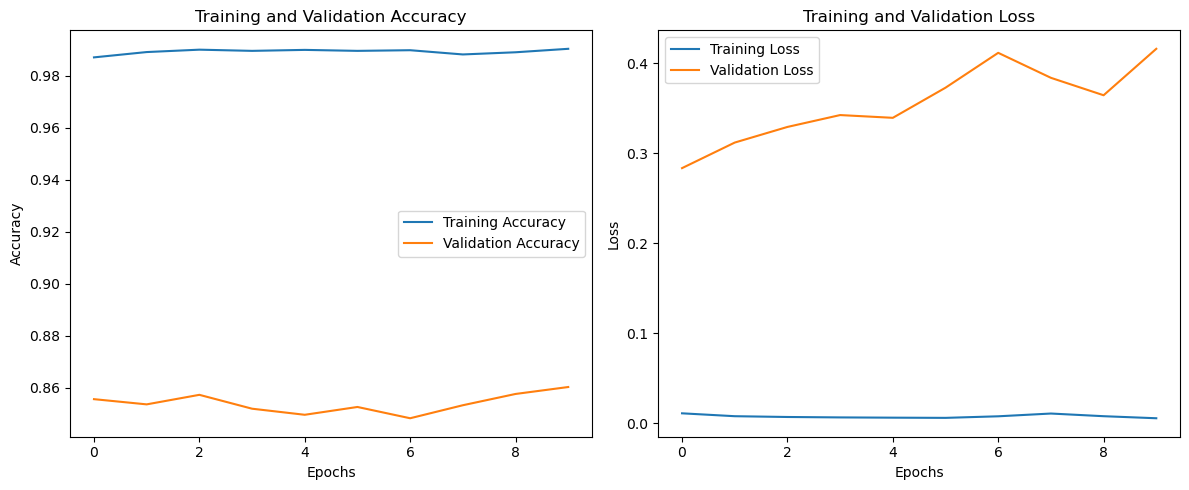

In [75]:
from keras.callbacks import History

# Define a custom History class to handle the absence of accuracy and loss
class MyHistory(History):
    def on_epoch_end(self, epoch, logs=None):
        if 'accuracy' not in logs:
            logs['accuracy'] = None
        if 'loss' not in logs:
            logs['loss'] = None
        if 'val_accuracy' not in logs:
            logs['val_accuracy'] = None
        if 'val_loss' not in logs:
            logs['val_loss'] = None
        super().on_epoch_end(epoch, logs)

# Create an instance of the custom history
history = MyHistory()

# Your model training code
model_ptw2v.fit(x_train_seq, onehotEncoding.GetOneHotEncodedMatrix(y_train).toarray(), validation_data=(x_val_seq, onehotEncoding.GetOneHotEncodedMatrix(y_validation).toarray()), epochs=10, batch_size=32, verbose=2, callbacks=[history])

# Plot the learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [73]:
loss, accuracy = model_ptw2v.evaluate(x_train_seq, onehotEncoding.GetOneHotEncodedMatrix(y_train).toarray(), verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 99.070835


In [51]:
#This code will take more than 1 hour to execute for 5 epochs
from keras.layers import Conv1D, GlobalMaxPooling1D
emotionCNNModel = Sequential()
e = Embedding(wordCount, matrixSize,input_length=vectorLenth)
emotionCNNModel.add(e)
# we are adding 100 filters of stride size 1 
emotionCNNModel.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
# Global max pooling layer will extract maximum value from each filter by changung
# to a one dimensional vector
emotionCNNModel.add(GlobalMaxPooling1D())
emotionCNNModel.add(Dense(256, activation='relu'))
emotionCNNModel.add(Dense(5, activation='softmax'))
emotionCNNModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
emotionCNNModel.fit(x_train_seq, onehotEncoding.GetOneHotEncodedMatrix(y_train).toarray(), validation_data=(x_val_seq, onehotEncoding.GetOneHotEncodedMatrix(y_validation).toarray()), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
750/750 - 6919s - loss: 0.1801 - accuracy: 0.7899 - val_loss: 0.0732 - val_accuracy: 0.9287 - 6919s/epoch - 9s/step
Epoch 2/5
750/750 - 334s - loss: 0.0573 - accuracy: 0.9440 - val_loss: 0.0720 - val_accuracy: 0.9337 - 334s/epoch - 446ms/step
Epoch 3/5
750/750 - 307s - loss: 0.0464 - accuracy: 0.9532 - val_loss: 0.0734 - val_accuracy: 0.9290 - 307s/epoch - 410ms/step
Epoch 4/5
750/750 - 300s - loss: 0.0370 - accuracy: 0.9617 - val_loss: 0.0819 - val_accuracy: 0.9183 - 300s/epoch - 400ms/step
Epoch 5/5
750/750 - 32875s - loss: 0.0275 - accuracy: 0.9730 - val_loss: 0.0951 - val_accuracy: 0.9183 - 32875s/epoch - 44s/step


In [53]:
loss, accuracy = emotionCNNModel.evaluate(x_train_seq, onehotEncoding.GetOneHotEncodedMatrix(y_train).toarray(), verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 97.829169


In [54]:
# Test Validation
x_test_tok_val = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(x_test_tok_val, maxlen=vectorLenth)


In [55]:
#Predicting the sequenced values
predictedModel = emotionCNNModel.predict(x_test_seq)
# Finding the class from predicted values
labelledPredictedModel = np.argmax(predictedModel, axis=-1)    


94/94 [==============================] - 0s 3ms/step


In [56]:
# converting encoded values to actual classes
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
labelEncoded = labelEncoder.fit_transform(emotions)
classPredictedModel = labelEncoder.inverse_transform(labelledPredictedModel)

In [57]:
#Analysing performance metrics
from DataClean import PerformanceMetrices
modelMetrices = PerformanceMetrices()
print(modelMetrices.Accuracy(classPredictedModel,y_test))
print(modelMetrices.Confusion_matrix(classPredictedModel,y_test))


0.913
[[570  25   5  21   4]
 [ 15 519   9  12  61]
 [  5   0 562   7   4]
 [  7   5  13 575   2]
 [  2  49  13   2 513]]


In [58]:
from sklearn.metrics import precision_recall_fscore_support
precision , recall , fbetascore, support = precision_recall_fscore_support(y_test, classPredictedModel, average='macro')


In [59]:
print("Precision : " + str(precision) +"\nRecall : " + str(recall) + '\nFScore : ' + str(fbetascore) )


Precision : 0.9136021341976488
Recall : 0.9126774230444893
FScore : 0.9129074127592496


In [60]:
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred = lb.transform(classPredictedModel)
print("ROC score : " + str(roc_auc_score(y_test, y_pred)))


ROC score : 0.9454776615404816


In [61]:
#Reference : https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


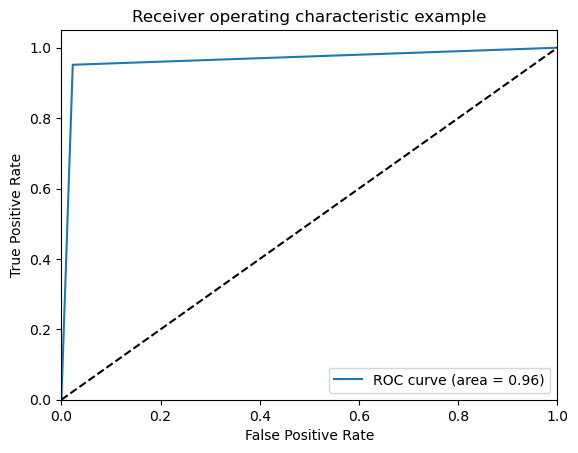

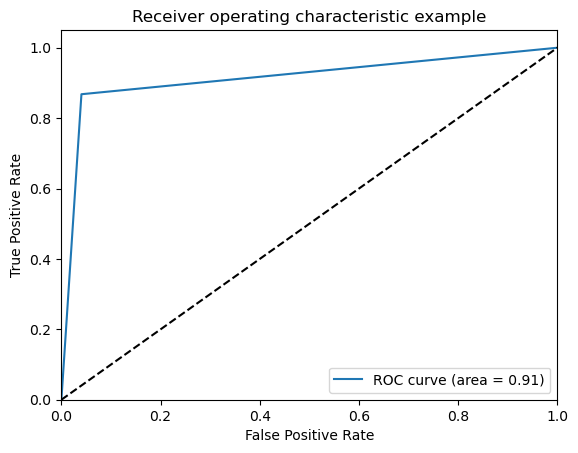

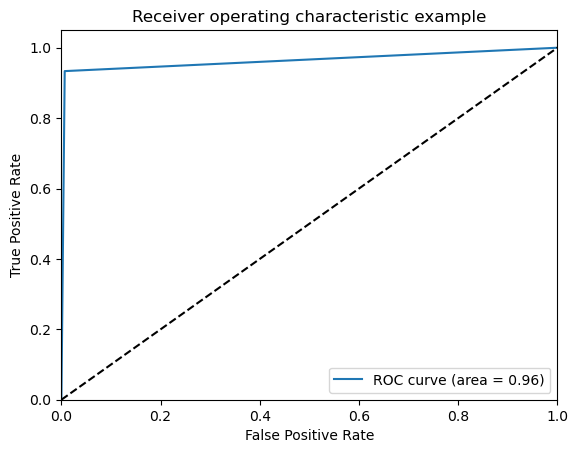

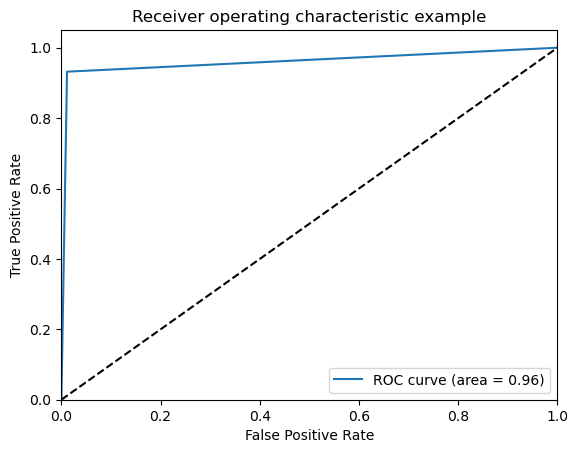

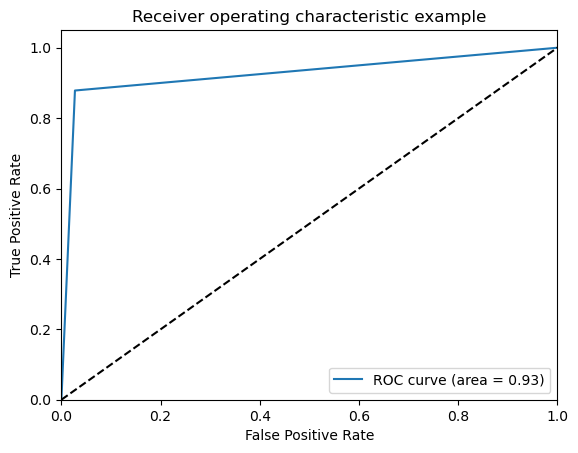

In [62]:
import matplotlib.pyplot as plt
# Plot of a ROC curve for a specific class
for i in range(5):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


In [64]:
from wordcloud import WordCloud


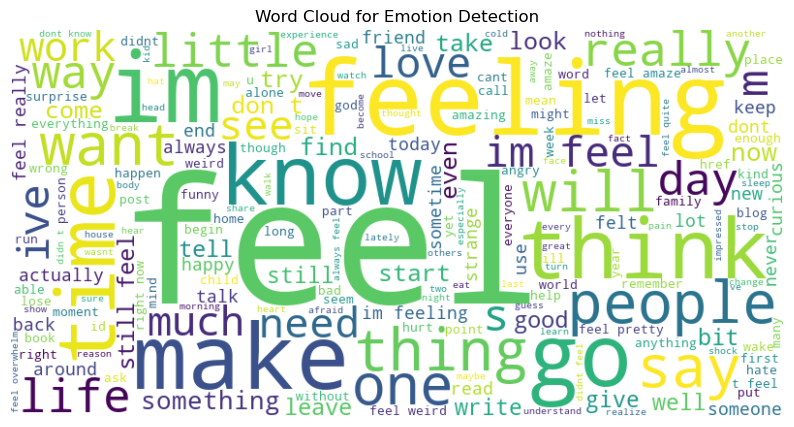

In [65]:
# Create a WordCloud from cleaned sentences
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sentences))

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Emotion Detection')
plt.show()